#### 1. Data collection

In [8]:
import FinanceDataReader as fdr
import html5lib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os

In [11]:
# test

# KOSPI index, 2010 ~ Now
kospi = fdr.DataReader('KS11', '2010-01-01')

# Indexes, 2010 ~ Now
dji = fdr.DataReader('DJI', '2010-01-01') # Dow Jones Industrial(DJI)
sp500 = fdr.DataReader('US500', '2010-01-01') # S&P 500 지수 (NYSE)

# FX 환율, 2010 ~ 현재
usdkrw = fdr.DataReader('USD/KRW', '2010-01-01') # 달러 원화
usdeur = fdr.DataReader('USD/EUR', '2010-01-01') # 달러 유로화
usdcny = fdr.DataReader('USD/CNY', '2010-01-01') # 달러 위엔화

# 상품 선물 가격 데이터
gold = fdr.DataReader('ZG', '2010-01-01') # 금 선물 (ICE)

# 채권 수익률
kr1yt = fdr.DataReader('KR1YT=RR', '2010-01-01') # 1년만기 한국국채 수익률
kr10yt = fdr.DataReader('KR10YT=RR', '2010-01-01') # 10년만기 한국국채 수익률
us1yt = fdr.DataReader('US1MT=X', '2010-01-01') # 1개월 만기 미국국채 수익률
us10yt = fdr.DataReader('US10YT=X', '2010-01-01') # 10년 만기 미국국채 수익률

# FRED 데이터
nasdaq = fdr.DataReader('NASDAQCOM', '2010-01-01', data_source='fred') # NASDAQCOM 나스닥종합지수
# hou_nas = fdr.DataReader(['HSN1F', 'NASDAQCOM'], data_source='fred') # HSN1F 주택판매지수, NASDAQCOM 나스닥종합지수

sse = fdr.DataReader('005930', '2010-01-01')

#### 2. Preprocessing

In [12]:
nasdaq.head()

,NASDAQCOM
DATE,
2010-01-04,2308.42
2010-01-05,2308.71
2010-01-06,2301.09
2010-01-07,2300.05
2010-01-08,2317.17


In [13]:
kospi_m = pd.DataFrame(data=kospi.Close.values, columns=['kospi'], index=kospi.index)
dji_m = pd.DataFrame(data=dji.Close.values, columns=['dji'], index=dji.index)
sp500_m = pd.DataFrame(data=sp500.Close.values, columns=['sp500'], index=sp500.index)

usdkrw_m = pd.DataFrame(data=usdkrw.Close.values, columns=['usdkrw'], index=usdkrw.index)
usdeur_m = pd.DataFrame(data=usdeur.Close.values, columns=['usdeur'], index=usdeur.index)
usdcny_m = pd.DataFrame(data=usdcny.Close.values, columns=['usdcny'], index=usdcny.index)

gold_m = pd.DataFrame(data=gold.Close.values, columns=['gold'], index=gold.index)

kr1yt_m = pd.DataFrame(data=kr1yt.Close.values, columns=['kr1yt'], index=kr1yt.index)
kr10yt_m = pd.DataFrame(data=kr10yt.Close.values, columns=['kr10yt'], index=kr10yt.index)
us1yt_m = pd.DataFrame(data=us1yt.Close.values, columns=['us1yt'], index=us1yt.index)
us10yt_m = pd.DataFrame(data=us10yt.Close.values, columns=['us10yt'], index=us10yt.index)

nasdaq_m = pd.DataFrame(data=nasdaq.NASDAQCOM.values, columns=['nasdaq'], index=nasdaq.index)

sse_m = pd.DataFrame(data=sse.Close.values, columns=['sse'], index=sse.index)

In [160]:
x_columns = [kospi_m, dji_m, sp500_m, usdkrw_m, usdeur_m, usdcny_m, gold_m, \
             kr1yt_m, kr10yt_m, us1yt_m, us10yt_m, nasdaq_m, sse_m]

In [161]:
df = pd.concat(x_columns, axis=1)

In [162]:
df.head()

,kospi,dji,sp500,usdkrw,usdeur,usdcny,gold,kr1yt,kr10yt,us1yt,us10yt,nasdaq,sse
2010-01-01,NaN,NaN,NaN,1166.08,0.6981,6.8270,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,1696.14,10583.96,1132.99,1150.00,0.6937,6.8285,1117.7,3.47,5.42,0.046,3.823,2308.42,16180.0
2010-01-05,1690.62,10572.02,1136.52,1140.20,0.6960,6.8268,1118.1,NaN,5.36,0.036,3.763,2308.71,16440.0
2010-01-06,1705.32,10573.68,1137.14,1129.20,0.6938,6.8278,1135.9,3.44,5.38,0.025,3.829,2301.09,16820.0
2010-01-07,1683.45,10606.86,1141.69,1138.20,0.6985,6.8281,1133.1,3.43,5.30,0.020,3.827,2300.05,16260.0


In [163]:
# df_dropna = df.dropna(axis=0, how='any')
df_dropna = df.fillna(method='ffill')

In [164]:
df_dropna.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4139 entries, 2010-01-01 to 2022-06-10
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kospi   4138 non-null   float64
 1   dji     4138 non-null   float64
 2   sp500   4138 non-null   float64
 3   usdkrw  4139 non-null   float64
 4   usdeur  4139 non-null   float64
 5   usdcny  4139 non-null   float64
 6   gold    4138 non-null   float64
 7   kr1yt   4138 non-null   float64
 8   kr10yt  4138 non-null   float64
 9   us1yt   4138 non-null   float64
 10  us10yt  4138 non-null   float64
 11  nasdaq  4138 non-null   float64
 12  sse     4138 non-null   float64
dtypes: float64(13)
memory usage: 452.7 KB


In [165]:
df_dropna = df_dropna.drop(['2010-01-01'])

In [166]:
df_dropna.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4138 entries, 2010-01-04 to 2022-06-10
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kospi   4138 non-null   float64
 1   dji     4138 non-null   float64
 2   sp500   4138 non-null   float64
 3   usdkrw  4138 non-null   float64
 4   usdeur  4138 non-null   float64
 5   usdcny  4138 non-null   float64
 6   gold    4138 non-null   float64
 7   kr1yt   4138 non-null   float64
 8   kr10yt  4138 non-null   float64
 9   us1yt   4138 non-null   float64
 10  us10yt  4138 non-null   float64
 11  nasdaq  4138 non-null   float64
 12  sse     4138 non-null   float64
dtypes: float64(13)
memory usage: 452.6 KB


In [167]:
full_df = df_dropna.reset_index()

In [168]:
full_df.head()

,index,kospi,dji,sp500,usdkrw,usdeur,usdcny,gold,kr1yt,kr10yt,us1yt,us10yt,nasdaq,sse
0,2010-01-04,1696.14,10583.96,1132.99,1150.00,0.6937,6.8285,1117.7,3.47,5.42,0.046,3.823,2308.42,16180.0
1,2010-01-05,1690.62,10572.02,1136.52,1140.20,0.6960,6.8268,1118.1,3.47,5.36,0.036,3.763,2308.71,16440.0
2,2010-01-06,1705.32,10573.68,1137.14,1129.20,0.6938,6.8278,1135.9,3.44,5.38,0.025,3.829,2301.09,16820.0
3,2010-01-07,1683.45,10606.86,1141.69,1138.20,0.6985,6.8281,1133.1,3.43,5.30,0.020,3.827,2300.05,16260.0
4,2010-01-08,1695.26,10618.19,1144.98,1128.25,0.6937,6.8276,1138.2,3.35,5.33,0.020,3.836,2317.17,16420.0


In [169]:
last_index = full_df.index[(full_df['index'] == '2020-05-19')].tolist()[0]
last_index

3395

In [170]:
# Truncate df until 2020-05-19

truncated_df = full_df[:last_index+1]

In [171]:
truncated_df.tail(20)

,index,kospi,dji,sp500,usdkrw,usdeur,usdcny,gold,kr1yt,kr10yt,us1yt,us10yt,nasdaq,sse
3376,2020-04-30,1947.56,24345.72,2912.43,1212.94,0.9125,7.0600,1694.2,0.806,1.517,0.0890,0.646,8889.551,50000.0
3377,2020-05-01,1947.56,23723.69,2830.71,1224.89,0.9105,7.0602,1700.9,0.806,1.517,0.1010,0.618,8604.949,50000.0
3378,2020-05-02,1947.56,23723.69,2830.71,1224.89,0.9105,7.0602,1700.9,0.806,1.517,0.1010,0.618,8604.949,50000.0
3379,2020-05-03,1947.56,23723.69,2830.71,1224.89,0.9105,7.0602,1700.9,0.806,1.517,0.1014,0.618,8604.949,50000.0
3380,2020-05-04,1895.37,23749.76,2842.74,1224.14,0.9166,7.0622,1713.3,0.795,1.499,0.0940,0.631,8710.715,48500.0
3381,2020-05-05,1895.37,23883.09,2868.44,1222.47,0.9227,7.0622,1710.6,0.795,1.496,0.0940,0.662,8809.121,48500.0
3382,2020-05-06,1928.76,23664.64,2848.42,1228.55,0.9263,7.1031,1688.5,0.786,1.506,0.0860,0.709,8854.387,49200.0
3383,2020-05-07,1928.61,23875.89,2881.19,1219.61,0.9228,7.0825,1725.8,0.774,1.486,0.0840,0.639,8979.660,48800.0
3384,2020-05-08,1945.82,24331.32,2929.80,1219.65,0.9224,7.0732,1713.9,0.762,1.426,0.0960,0.685,9121.320,48800.0
3385,2020-05-09,1945.82,24331.32,2929.80,1219.65,0.9224,7.0732,1713.9,0.757,1.425,0.0960,0.685,9121.320,48800.0


In [172]:
split_index = truncated_df.index[(truncated_df['index'] == '2020-05-02')].tolist()[0]
split_index

3378

In [173]:
truncated_df = truncated_df.drop('index', axis=1)

In [174]:
# X_train, X_val, X_test = truncated_df[:int(len(truncated_df)*0.9)], \
#                          truncated_df[int(len(truncated_df)*0.9):2268], \
#                          truncated_df[2268:2278]

X_train, X_test = truncated_df[:split_index], truncated_df[split_index:last_index]

In [175]:
X_test.tail()

,kospi,dji,sp500,usdkrw,usdeur,usdcny,gold,kr1yt,kr10yt,us1yt,us10yt,nasdaq,sse
3390,1924.96,23625.34,2852.50,1227.03,0.9254,7.0935,1740.9,0.751,1.382,0.0840,0.617,8943.723,48000.0
3391,1927.28,23685.42,2863.70,1232.69,0.9245,7.1013,1756.3,0.748,1.384,0.0940,0.644,9014.559,47850.0
3392,1927.28,23685.42,2863.70,1232.69,0.9245,7.1013,1756.3,0.742,1.377,0.0940,0.644,9014.559,47850.0
3393,1927.28,23685.42,2863.70,1232.69,0.9245,7.1013,1756.3,0.742,1.377,0.1217,0.643,9014.559,47850.0
3394,1937.11,24597.37,2953.91,1225.13,0.9163,7.1086,1734.4,0.736,1.392,0.0910,0.726,9234.828,48800.0


In [176]:
print(X_train.shape, X_test.shape)

(3378, 13) (17, 13)


In [177]:
y_train, y_test = truncated_df[['kospi']][1:split_index+1], \
                  truncated_df[['kospi']][split_index+1:]

In [178]:
y_test.tail()

,kospi
3391,1927.28
3392,1927.28
3393,1927.28
3394,1937.11
3395,1980.61


In [179]:
print(y_train.shape, y_test.shape)

(3378, 1) (17, 1)


In [180]:
# Backup data

file_name = 'truncated_df.xlsx'
truncated_df.to_excel(file_name)

### 2-2 Normalization

In [181]:
from sklearn.preprocessing import MinMaxScaler

In [182]:
minMaxScaler = MinMaxScaler()
minMaxScaler.fit(X_train)
scaled_X_train = minMaxScaler.transform(X_train)

In [183]:
scaled_X_test = minMaxScaler.transform(X_test)

#### 3. Learning

- 3-1) XGBoost

In [184]:
import xgboost
import math
from sklearn.metrics import mean_squared_error

In [185]:
xgb_model = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

In [186]:
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.08, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

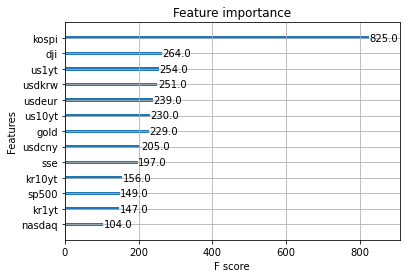

In [187]:
xgboost.plot_importance(xgb_model)

In [188]:
predictions = xgb_model.predict(X_test)
predictions

array([1948.4064, 1948.4064, 1895.4456, 1895.4045, 1936.9751, 1937.7408,
       1945.7427, 1945.7427, 1945.7427, 1942.9784, 1928.809 , 1952.2196,
       1933.087 , 1938.4053, 1938.4053, 1939.7557, 1950.1633],
      dtype=float32)

In [189]:
mse = mean_squared_error(y_test, predictions)
print('mse :', mse)
print('rmse :', math.sqrt(mse))

mse : 393.79718954187854
rmse : 19.84432386204878


In [190]:
xgb_model.fit(scaled_X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.08, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [191]:
predictions = xgb_model.predict(scaled_X_test)
predictions

array([1948.4064, 1948.4064, 1895.4456, 1895.4045, 1936.9751, 1937.7408,
       1945.7427, 1945.7427, 1945.7427, 1942.9784, 1928.809 , 1952.2196,
       1933.087 , 1938.4053, 1938.4053, 1939.7557, 1950.1633],
      dtype=float32)

In [192]:
mse = mean_squared_error(y_test, predictions)
print('mse :', mse)
print('rmse :', math.sqrt(mse))

mse : 393.79718954187854
rmse : 19.84432386204878


- 3-2) XGBRegressor with GridSearchCV

In [193]:
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV

In [194]:
# Various hyper-parameters to tune

xgb1 = XGBRegressor()
parameters = {'nthread':[3], # when use hyperthread, xgboost may become slower
              'learning_rate': [0.01, 0.03, 0.05, 0.07, 0.09],
              'max_depth': [3, 4, 5, 6, 7],
              'min_child_weight': [3, 4, 5],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [100, 300, 500]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_train, y_train)

Fitting 2 folds for each of 225 candidates, totalling 450 fits


GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None,
                               

In [195]:
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

0.6687807338745266
{'colsample_bytree': 0.7, 'learning_rate': 0.09, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 3, 'subsample': 0.7}


In [196]:
predictions = xgb_grid.predict(X_test)
predictions

array([1946.4404, 1946.4404, 1900.9315, 1904.6732, 1951.8751, 1945.666 ,
       1958.4878, 1958.4878, 1959.6489, 1965.9458, 1939.7062, 1959.2467,
       1942.8761, 1956.902 , 1956.0214, 1957.0908, 1961.0247],
      dtype=float32)

In [197]:
mse = mean_squared_error(y_test, predictions)
print('mse :', mse)
print('rmse :', math.sqrt(mse))

mse : 617.2226276693967
rmse : 24.843965618825766


In [198]:
xgb_grid.fit(scaled_X_train, y_train)

Fitting 2 folds for each of 225 candidates, totalling 450 fits


GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None,
                               

In [199]:
predictions = xgb_grid.predict(scaled_X_test)
predictions

array([1950.8118, 1950.8118, 1899.3528, 1905.3301, 1948.7778, 1943.6339,
       1959.1732, 1959.1732, 1961.9503, 1960.5734, 1937.3267, 1956.2965,
       1941.4552, 1952.5127, 1950.0066, 1950.0468, 1953.2429],
      dtype=float32)

In [200]:
mse = mean_squared_error(y_test, predictions)
print('mse :', mse)
print('rmse :', math.sqrt(mse))

mse : 579.9439870098399
rmse : 24.0820262230951


- 3-3) LSTM

In [201]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [202]:
scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = truncated_df.columns.tolist()

# 스케일 후 columns
scaled = scaler.fit_transform(truncated_df)
scaled

array([[0.20910964, 0.04517909, 0.04671323, ..., 0.95212156, 0.0280413 ,
        0.05286885],
       [0.20426987, 0.04457804, 0.04820674, ..., 0.93491972, 0.02807884,
        0.05819672],
       [0.21715839, 0.0446616 , 0.04846905, ..., 0.95384174, 0.02709248,
        0.06598361],
       ...,
       [0.41176625, 0.70470588, 0.77895726, ..., 0.04042431, 0.89610609,
        0.70184426],
       [0.4203849 , 0.75061339, 0.8171241 , ..., 0.06422018, 0.92461843,
        0.72131148],
       [0.4585244 , 0.73095514, 0.80402104, ..., 0.05447248, 0.91818212,
        0.75204918]])

In [203]:
df = pd.DataFrame(scaled, columns=scale_cols)

In [204]:
# # Normalization 미적용

# df = truncated_df.copy()
# df

In [205]:
X_train, X_test, y_train, y_test = train_test_split(df, \
    df['kospi'], test_size=0.2, random_state=0, shuffle=False)

In [206]:
X_train.shape, y_train.shape

((2716, 13), (2716,))

In [207]:
X_test.shape, y_test.shape

((680, 13), (680,))

In [208]:
X_train

,kospi,dji,sp500,usdkrw,usdeur,usdcny,gold,kr1yt,kr10yt,us1yt,us10yt,nasdaq,sse
0,0.209110,0.045179,0.046713,0.534663,0.066944,0.692193,0.081049,0.906005,1.000000,0.034469,0.952122,0.028041,0.052869
1,0.204270,0.044578,0.048207,0.497436,0.074922,0.690698,0.081526,0.906005,0.988930,0.030507,0.934920,0.028079,0.058197
2,0.217158,0.044662,0.048469,0.455651,0.067291,0.691577,0.102741,0.898172,0.992620,0.026149,0.953842,0.027092,0.065984
3,0.197983,0.046332,0.050394,0.489839,0.083593,0.691841,0.099404,0.895561,0.977860,0.024168,0.953268,0.026958,0.054508
4,0.208338,0.046902,0.051786,0.452042,0.066944,0.691401,0.105483,0.874674,0.983395,0.024168,0.955849,0.029174,0.057787
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2711,0.761466,0.734205,0.717470,0.401861,0.629206,0.509759,0.244100,0.481723,0.471402,0.713154,0.676032,0.701390,0.677254
2712,0.761466,0.734205,0.717470,0.401861,0.629206,0.509759,0.244100,0.481723,0.471402,0.713154,0.676032,0.701390,0.677254
2713,0.761466,0.734205,0.717470,0.401861,0.629206,0.509759,0.244100,0.481723,0.471402,0.709984,0.674885,0.701390,0.677254
2714,0.713603,0.736005,0.720998,0.416448,0.640652,0.551081,0.228844,0.481723,0.466974,0.755151,0.679186,0.708818,0.654713


In [209]:
import tensorflow as tf

https://webnautes.tistory.com/1527

In [210]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=7, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [211]:
WINDOW_SIZE = 20
BATCH_SIZE = 32

In [212]:
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [213]:
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


In [214]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [215]:
model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=12,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [216]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [217]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [218]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=100, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/100


2022-06-10 13:32:23.644905: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-10 13:32:23.797447: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


      5/Unknown - 1s 15ms/step - loss: 0.0960 - mse: 0.1919 

2022-06-10 13:32:23.872792: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


     13/Unknown - 1s 19ms/step - loss: 0.0738 - mse: 0.1476
Epoch 00001: val_loss improved from inf to 0.04447, saving model to tmp/ckeckpointer.ckpt
13/13 [==============================] - 1s 44ms/step - loss: 0.0738 - mse: 0.1476 - val_loss: 0.0445 - val_mse: 0.0889


2022-06-10 13:32:24.313586: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-10 13:32:24.373732: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 2/100
10/13 [======================>.......] - ETA: 0s - loss: 0.0231 - mse: 0.0462
Epoch 00002: val_loss improved from 0.04447 to 0.00408, saving model to tmp/ckeckpointer.ckpt
13/13 [==============================] - 0s 17ms/step - loss: 0.0205 - mse: 0.0410 - val_loss: 0.0041 - val_mse: 0.0082
Epoch 3/100
10/13 [======================>.......] - ETA: 0s - loss: 0.0038 - mse: 0.0076
Epoch 00003: val_loss improved from 0.00408 to 0.00393, saving model to tmp/ckeckpointer.ckpt
13/13 [==============================] - 0s 16ms/step - loss: 0.0039 - mse: 0.0078 - val_loss: 0.0039 - val_mse: 0.0079
Epoch 4/100
11/13 [========================>.....] - ETA: 0s - loss: 0.0036 - mse: 0.0072
Epoch 00004: val_loss improved from 0.00393 to 0.00224, saving model to tmp/ckeckpointer.ckpt
13/13 [==============================] - 0s 16ms/step - loss: 0.0035 - mse: 0.0071 - val_loss: 0.0022 - val_mse: 0.0045
Epoch 5/100
11/13 [========================>.....] - ETA: 0s - loss: 0.0025 - mse: 0.005

In [219]:
model.load_weights(filename)

In [220]:
pred = model.predict(test_data)

2022-06-10 13:32:51.266842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-10 13:32:51.311778: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [221]:
pred.shape

(95, 1)

In [222]:
test = []
for i, value in enumerate(y_test):
    if (i+1) % 7 == 0:
        test.append(value)

In [223]:
test = test[1:]
print(len(test))

96


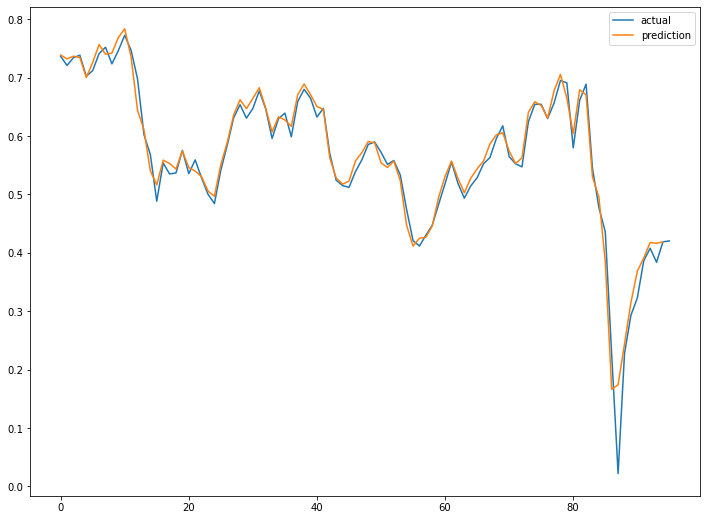

In [224]:
plt.figure(figsize=(12, 9))
# plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(test, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()